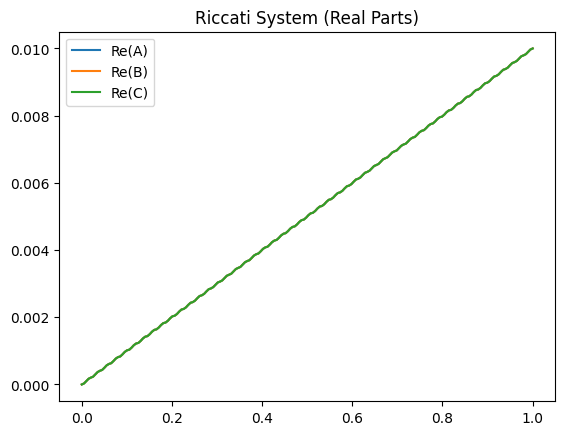

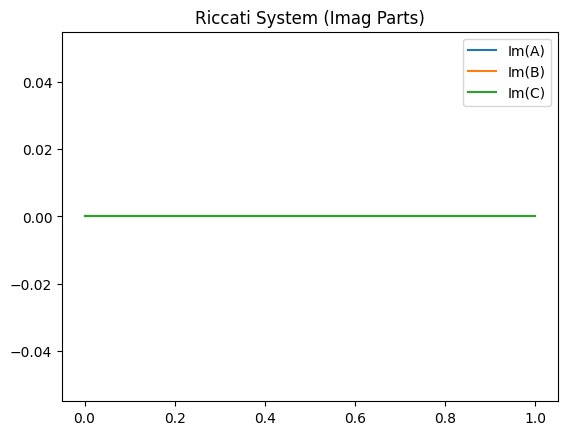

In [10]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt

# Riccati system (split real/imag)
def riccati_system(h, y, params):
    s, mu_h, sigma_h, beta_X, mu_X_lambda, beta_Y, mu_Y_lambda, \
    eta_X, delta_X, alpha_XX, alpha_XY, eta_Y, delta_Y, alpha_YY, alpha_YX = params

    # Reconstruct complex vars
    A  = y[0] + 1j*y[1]
    Ap = y[2] + 1j*y[3]
    B  = y[4] + 1j*y[5]
    Bp = y[6] + 1j*y[7]
    C  = y[8] + 1j*y[9]
    Cp = y[10] + 1j*y[11]

    # Second derivatives (complex)
    A_pp = (-2/sigma_h**2) * (
        mu_h*Ap 
        + 0.5*sigma_h**2*(Ap**2)
        + beta_X*mu_X_lambda*B
        + beta_Y*mu_Y_lambda*C
        + 1j*s
    )

    B_pp = (-2/sigma_h**2) * (
        mu_h*Bp
        + 0.5*sigma_h**2*(Bp**2 + 2j*s*Ap*Bp)
        - beta_X*B
        + (eta_X/(eta_X + 1j*s*Ap)) *
          np.exp(1j*s*Ap*delta_X - alpha_XX*B - alpha_XY*C) - 1
    )

    C_pp = (-2/sigma_h**2) * (
        mu_h*Cp
        + 0.5*sigma_h**2*(Cp**2 + 2j*s*Ap*Cp)
        - beta_Y*C
        + (eta_Y/(eta_Y - 1j*s*Ap)) *
          np.exp(-1j*s*Ap*delta_Y - alpha_YY*C - alpha_YX*B) - 1
    )

    return np.vstack([
        y[2], y[3],
        A_pp.real, A_pp.imag,
        y[6], y[7],
        B_pp.real, B_pp.imag,
        y[10], y[11],
        C_pp.real, C_pp.imag
    ])

# Boundary conditions
def bc(ya, yb):
    return np.array([
        ya[0], ya[1],  # Re(A(0)), Im(A(0))
        ya[4], ya[5],  # Re(B(0)), Im(B(0))
        ya[8], ya[9],  # Re(C(0)), Im(C(0))
        1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10  # free derivatives
    ])

# Example params
params = [
    10.0,   # s
    0.1,   # mu_h
    0.2,   # sigma_h
    0.5,   # beta_X
    0.1,   # mu_X_lambda
    0.5,   # beta_Y
    0.1,   # mu_Y_lambda
    100.0,   # eta_X
    0.005,  # delta_X
    0.2,   # alpha_XX
    0.1,   # alpha_XY
    100.0,   # eta_Y
    0.005,  # delta_Y
    0.2,   # alpha_YY
    0.1    # alpha_YX
]

# Mesh + initial guess
h_mesh = np.linspace(0, 1, 50)
y_init = np.zeros((12, h_mesh.size))
y_init[0] = 0.01 * h_mesh
y_init[4] = 0.01 * h_mesh
y_init[8] = 0.01 * h_mesh

# Solve
solution = solve_bvp(lambda h, y: riccati_system(h, y, params), bc,
                     h_mesh, y_init, max_nodes=5000)

# Evaluate
h_eval = np.linspace(0, 1, 200)
sol_eval = solution.sol(h_eval)
A_sol = sol_eval[0] + 1j*sol_eval[1]
B_sol = sol_eval[4] + 1j*sol_eval[5]
C_sol = sol_eval[8] + 1j*sol_eval[9]

# Plot real parts
plt.figure()
plt.plot(h_eval, A_sol.real, label="Re(A)")
plt.plot(h_eval, B_sol.real, label="Re(B)")
plt.plot(h_eval, C_sol.real, label="Re(C)")
plt.legend(); plt.title("Riccati System (Real Parts)")
plt.show()

# Plot imaginary parts
plt.figure()
plt.plot(h_eval, A_sol.imag, label="Im(A)")
plt.plot(h_eval, B_sol.imag, label="Im(B)")
plt.plot(h_eval, C_sol.imag, label="Im(C)")
plt.legend(); plt.title("Riccati System (Imag Parts)")
plt.show()


/var/folders/cx/r29qtv6d47gc4c3vgvtvlgth0000gn/T/ipykernel_21054/3438457265.py:16: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  val, _ = quad(integrand, 0, np.inf, limit=2000, epsabs=1e-6)


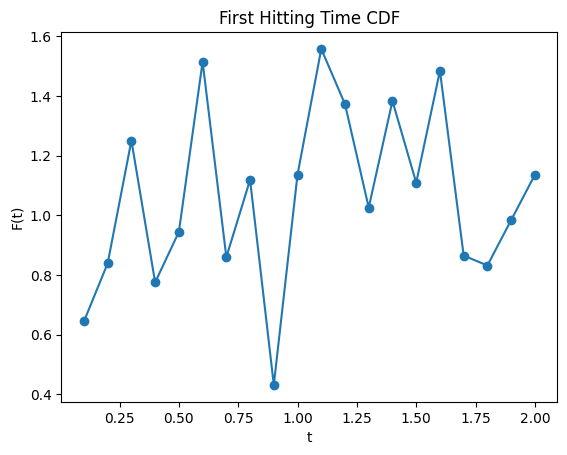

In [11]:
from scipy.integrate import quad

# Characteristic function at given s, using final values of A,B,C
def characteristic_function(s, h0, lambdaX0, lambdaY0, solution):
    # Evaluate A,B,C at initial h0
    vals = solution.sol([h0])
    A = vals[0][0] + 1j*vals[1][0]
    B = vals[4][0] + 1j*vals[5][0]
    C = vals[8][0] + 1j*vals[9][0]
    return np.exp(1j*s*A + B*lambdaX0 + C*lambdaY0)

# Invert to get CDF F(t)
def hitting_time_cdf(t, h0, lambdaX0, lambdaY0, solution):
    integrand = lambda u: np.imag(np.exp(-1j*u*t) *
                                  characteristic_function(u, h0, lambdaX0, lambdaY0, solution)) / u
    val, _ = quad(integrand, 0, np.inf, limit=2000, epsabs=1e-6)
    return 0.5 - val/np.pi

# Example usage
h0 = 0.5
lambdaX0 = 0.0
lambdaY0 = 0.0
t_eval = np.linspace(0.1, 2.0, 20)
cdf_vals = [hitting_time_cdf(t, h0, lambdaX0, lambdaY0, solution) for t in t_eval]

plt.figure()
plt.plot(t_eval, cdf_vals, marker='o')
plt.title("First Hitting Time CDF")
plt.xlabel("t")
plt.ylabel("F(t)")
plt.show()
